<a href="https://colab.research.google.com/github/xwinxu/model-optimization/blob/tf2first/TFMOT_LTHipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Sparse Subnetworks via Lottery Tickets

Welcome to an end-to-end example of using the new TF2.0 first Tensorflow Model Optimization Toolkit (TFMOT) prototype in actualizing a current popular sparsity training technique.

# Introduction
Sparse network training (e.g. network pruning and quantization) is a technique that brings efficiency to otherwise difficult to optimize dense training procedures. This tutorial will demonstrate how to leverage sparsity to train models using the Tensorflow Model Optimization Toolkit's new pruning API and the implemented Lottery Ticket seeking pruning method. Here we focus on low magnitude pruning as the unstructured pruning criterion.

## Overview: Iterative Magnitude Pruning

With recent advances in sparse neural network training techniques, there has been a line of work on Lottery Ticket Winners [[Frankle & Carbin, 2019]](https://arxiv.org/abs/1803.03635) which purports that all dense, randomly intialized neural networks contain sparse subnetworks (i.e. "winning tickets") that when trained in isolation, can achieve comparable accuracy within the same number of iterations expected of from the originally dense network to reach convergence.

The final sparse network is achieved via iterative magnitude pruning (IMP):
1. Randomly initialize a NN
2. Train network to convergence
3. Prune k% (fraction) of lowest-magnitude weights
4. Reset each remaining weight to it's stored initialization
5. Train via steps 2-4 until the resulting pruned network reaches convergence

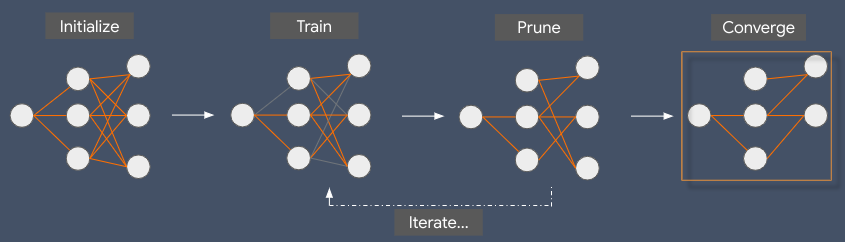



# Set-Up

In [ ]:
!git clone https://github.com/tomerk/model-optimization.git
!git checkout 

In [ ]:
!pip install tensorflow
!pip install --user --upgrade tensorflow-model-optimization 
!pip install tensorflow-datasets

In [ ]:
import os
import tensorflow as tf
import tensorflow_model_optimization as tfmot

import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters

Specify training parameters: `batch_size`, `epochs`, `num_classes` and pruning specific parameters: `reload_iteration` and `target_sparsity`.

In [ ]:
batch_size = 128
num_classes = 10
epochs = 1

reload_iteration = 0
target_sparsity = 0.5

# Load Data
The MNIST dataset can be downloaded from Tensorflow datasets.

`x_train` is the dataset of 28x28 pixel grayscale images of handwritten digits from 0-9

`x_test` is the dataset of labels that correspond to `x_train`

In [ ]:
n_rows, n_cols = 28, 28
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], n_rows*n_cols)
x_test = x_test.reshape(x_test.shape[0], n_rows*n_cols)
input_shape = (n_rows*n_cols*1,)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Model Definitiion

In [ ]:
def build_layerwise_model(input_shape, **pruning_params):
  return tf.keras.Sequential([
      l.Conv2D(
          32, 5, padding='same', activation='relu', input_shape=input_shape),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Conv2D(64, 5, padding='same'),
      l.BatchNormalization(),
      l.ReLU(),
      l.MaxPooling2D((2, 2), (2, 2), padding='same'),
      l.Flatten(),
      prune.prune_low_magnitude(
          l.Dense(1024, activation='relu'), **pruning_params),
      l.Dropout(0.4),
      prune.prune_low_magnitude(
          l.Dense(num_classes, activation='softmax'), **pruning_params)
  ])

# Train Procedure Definition

In [ ]:
def train(model, x_train, y_train, x_test, y_test, pruning_params):
  model = tfmot.sparsity_tf2.pruning_model.PrunableModel(model)
  pruning_config = tfmot.sparsity_tf2.prune.LowMagnitudePruningConfig(
      **pruning_params
  )
  model.compile(
      loss=tf.keras.losses.categorical_crossentropy,
      optimizer=tfmot.sparsity_tf2.pruning_optimizer.PruningOptimizer('adam', pruning_config),
      metrics=['accuracy'])

  # Print the model summary.
  model.summary()

  # Add a pruning step callback to peg the pruning step to the optimizer's
  # step. Also add a callback to add pruning summaries to tensorboard
  callbacks = [
    # TODO(xwinxu): do we need a pruning summary callback or can we just use the
      # standard tensorboard callback? (w/ summary logging in the pruning
      # model
  ]

  model.fit(
      x_train,
      y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      callbacks=callbacks,
      validation_data=(x_test, y_test))
  
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

  return model

# Train & Evaluate the Model
Here the LTH model weights are initialized from the first iteration (i.e. initialization) and we reload every 100 iterations.

In [ ]:
pruning_params = {
    'pruning_schedule':
        tfmot.ConstantSparsity(target_sparsity, begin_step=0, frequency=100),
    'block_size': (2, 2)
}

model = build_layerwise_model(input_shape, **pruning_params)
model = train(model, x_train, y_train, x_test, y_test, pruning_params)

## Convert and Train a TFLite Model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True

# Get a dense model as baseline
tflite_model_dense = converter.convert()
tflite_model_path = '/tmp/dense_mnist.tflite'
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model_dense)

# The _experimental_sparsify_model is to enable sparse tensor encoding,
# otherwise the model is converted as dense.
converter._experimental_sparsify_model = True

tflite_model = converter.convert()

# Check the model is compressed
print('Compression ratio: ', len(tflite_model) / len(tflite_model_dense))

tflite_model_path = '/tmp/sparse_mnist_%s_2x2.tflite' % FLAGS.sparsity
with open(tflite_model_path, 'wb') as f:
  f.write(tflite_model)

### Evaluate the TFLite Model

In [ ]:
print('evaluate 2x2 model')
print(keras_test_utils.eval_mnist_tflite(model_content=tflite_model))